In [1]:
import numpy as np
np.bool = np.bool_
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
from datetime import date, timedelta, datetime
import cartopy.crs as ccrs
import warnings
from mpl_toolkits.basemap import Basemap
warnings.filterwarnings('ignore')
from urllib.parse import quote
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import haversine -- doesn't work anymore for some reason
#    I found a new haversine, it has < 1% error:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

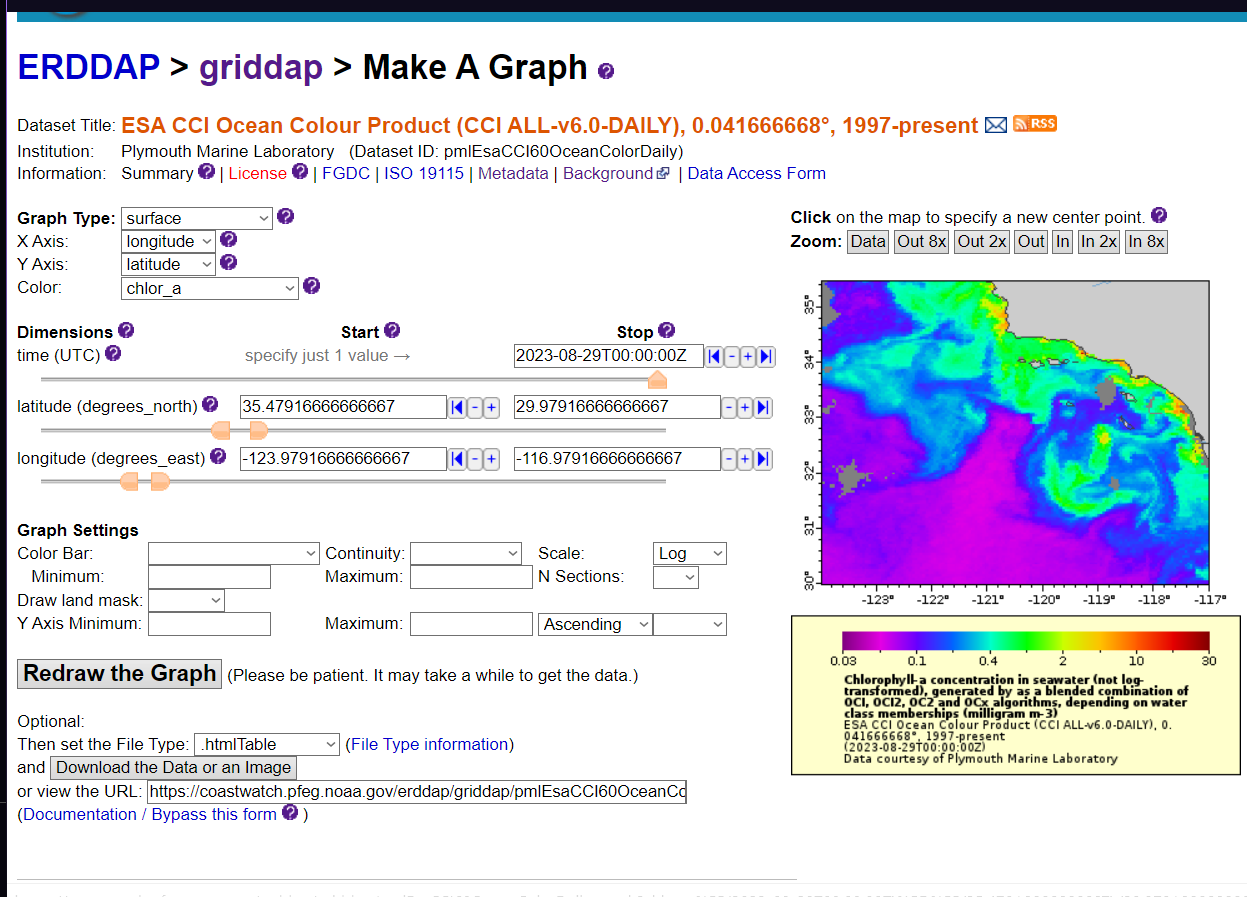

**Time Range**

I have a dataset from scripps pier that might be useful for connecting glider nighttime values to daytime, but the code is non-functional and not useful right now.

**Satellite Query**

In [41]:
def to_datetime(string):
    return datetime.strptime(string, "%Y-%m-%dT%H:%M:%SZ")

In [42]:
#download glider data and make it usable -- this is for the week corresponding to clear satellite data in the same region
glider = pd.read_csv('line80-satellitequery.csv')
units_g = glider.iloc[0].to_numpy()
glider = glider.drop(index = 0)
#select only surface depths (10m)
glider = glider[glider.get('depth') == '10.0']
glider['time'] = glider['time'].apply(to_datetime)
glider['depth'] = pd.to_numeric(glider['depth'], errors='coerce')
glider['chlorophyll'] = pd.to_numeric(glider['chlorophyll'], errors='coerce')
glider['latitude'] = pd.to_numeric(glider['latitude'], errors='coerce')
glider['longitude'] = pd.to_numeric(glider['longitude'], errors='coerce')
glider['profile'] = pd.to_numeric(glider['profile'], errors='coerce')
#get rid of chl NaN values
glider = glider[(glider.get('chlorophyll') >= 0) | (glider.get('chlorophyll') < 0)]

**URL Request - Incomplete**

In [19]:
col_names = ["iso_date", "matched_lat", "matched_lon", "matched_chla"]
tot = pd.DataFrame(columns=col_names)

# create variables for the unchanging parts of the ERDDAP data-request URL. 
base_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/'
dataset_id = "pmlEsaCCI60OceanColorDaily"
file_type = '.csv'
query_start = '?'
erddap_variable = 'chlor_a'

# create the start of the ERDDAP data-request URL by joining URL components
start_url = ''.join([base_url,
                     dataset_id,
                     file_type,
                     query_start,
                     erddap_variable
                     ])

In [ ]:
# Finish each URL and download
profile_arr = glider.get('profile').to_numpy()
for i in range(0, len(glider)):
    # for each row in the track data frame, create the query part of the ERDDAP data-request URL.
    query_url = ''.join([
                         '[(' + glider['date_str'].to_numpy()[i] + '):1:(' + glider['date_str'].to_numpy()[i] + ')]',
                         '[(' + glider['latitude_str'].to_numpy()[i] + '):1:(' + glider['latitude_str'].to_numpy()[i] + ')]', 
                         '[(' + glider['longitude_str'].to_numpy()[i] + '):1:(' + glider['longitude_str'].to_numpy()[i] + ')]'
                         ])
    encoded_query = quote(query_url, safe='')
    url = start_url + encoded_query
    print(i+1, 'of', len(glider), url)

    # download the data as a CSV file directly into Pandas
    new = pd.read_csv(url, skiprows=1)
    new.columns = col_names
    
    #assign profile number to query results
    new = new.reset_index()
    def assign_profile(index):
        return profile[i]
    new = new.assign(profile = new.get('index').apply(assign_profile))
    new = new.drop(columns = 'index')
    
    tot = pd.concat([tot, new], ignore_index=True)

https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.htmlTable?chlor_a%5B
(2023-08-28T00:00:00Z):1:(2023-08-28T00:00:00Z)%5D%5B
(45.97916666666667):1:(25.97916666666667)%5D%5B
(-135.97916666666669):1:(-115.97916666666667)%5D

* Request for range: time, lat, lon 
    - (values will automatically round to nearest, do not worry about tail of decimals)

In [47]:
satellite = pd.read_csv("satellite-satellitequery.csv")
satellite['chlor_a'] = pd.to_numeric(satellite['chlor_a'], errors = 'coerce')
satellite['longitude'] = pd.to_numeric(satellite['longitude'], errors = 'coerce')
satellite['latitude'] = pd.to_numeric(satellite['latitude'], errors = 'coerce')
units_s = satellite.iloc[0].to_numpy()
satellite = satellite.drop(index = 0)
satellite['time'] = satellite['time'].apply(to_datetime)
satellite = satellite[(satellite.get('chlor_a') >= 0) | (satellite.get('chlor_a') < 0)];
#starting range = 5km radius and 36hrs
#ideally I'd use a test time range of 120hrs, which allows for +-(2days+12hrs) of flexibility

In [51]:
#returns haversine distance in km
def myhaversine(lat1,lon1, lat2,lon2):
    loc1 = [lat1, lon1]
    loc2 = [lat2,lon2]
    loc1_rad = [radians(_) for _ in loc1]
    loc2_rad = [radians(_) for _ in loc2]
    dist = haversine_distances([loc1_rad,loc2_rad])
    return dist * 6371

In [36]:
#chatgpt code for finding a closest matchup using weights and a simple distance calculation. May be too inefficient to work for
#large requests, earlier steps to reduce the amount of data that will have to undergo these calculations may be neccessary
def custom_distance(lat1, lon1, time1, lat2, lon2, time2, spatial, temporal, spatial_weight=0.5):
    #temporal is time distance in hours
    #spatial is spatial distance in km
    #Calculate spatial distance using Haversine formula
    spatial_dist = myhaversine(lat1,lon1, lat2,lon2)
    
    # Calculate temporal distance (absolute difference in time) in minutes, currently it's 
    #nanoseconds but should be turned into a parameter later if that's useful
    temporal_dist = ((abs(time2 - time1)).astype(int))/(1e9*60*60)
    #filter distances by limits
    if (spatial_dist <= spatial) & (temporal_dist <= temporal):
        return spatial_dist, temporal_dist
    
    # Combine spatial and temporal distances using a weighted sum
    #distance = spatial_weight * spatial_dist + (1 - spatial_weight) * temporal_dist
    #return distance

In [49]:
print(np.max(glider.get('latitude')), np.min(glider.get('latitude')))
print(np.max(glider.get('longitude')), np.min(glider.get('longitude')))

33.42259 32.84645
-122.8049475 -123.7675
